In [1]:
import os
import cv2
import json
import time
import torch
import random
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFilter, ImageOps

img_size = 64

repo_dir = "c:/Users/James/git/de-identification/"
data_path = repo_dir+"downloaded-data/"
base_dir = "C:/Users/James/"


# Setting up Kaggle - copying api key from repo to .kaggle folder
with open(repo_dir+'kaggle-apikey.json') as f:
    kaggle_apikey = json.load(f)
kaggle_apikey

kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir)
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): 
    print("making folder: ", kaggle_dir)
    os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

#Checking it has been created correctly
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print('~/.kaggle/kaggle.json ==', f.read())

import kaggle

if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)
!kaggle config set -n path -v {data_path}

base_dir: C:/Users/James/
kaggle_dir: C:/Users/James/.kaggle
~/.kaggle/kaggle.json == {"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}
- path is now set to: c:/Users/James/git/de-identification/downloaded-data/


In [ ]:
### Downloading CelebA dataset ###
# ! kaggle datasets download jessicali9530/celeba-dataset 
zip_path = data_path+"datasets/jessicali9530/celeba-dataset/celeba-dataset.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)
#put in folder downloaded-data/img_align_celeba/img_align_celeba/[img1, img2, ...]

In [ ]:
### Downloading vin1234/count-the-number-of-faces-present-in-an-image ###
! kaggle datasets download vin1234/count-the-number-of-faces-present-in-an-image
zip_path = data_path+"datasets/vin1234/count-the-number-of-faces-present-in-an-image/count-the-number-of-faces-present-in-an-image.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)
# #put in folder downloaded-data/train/image_data/[img1, img2, ...]

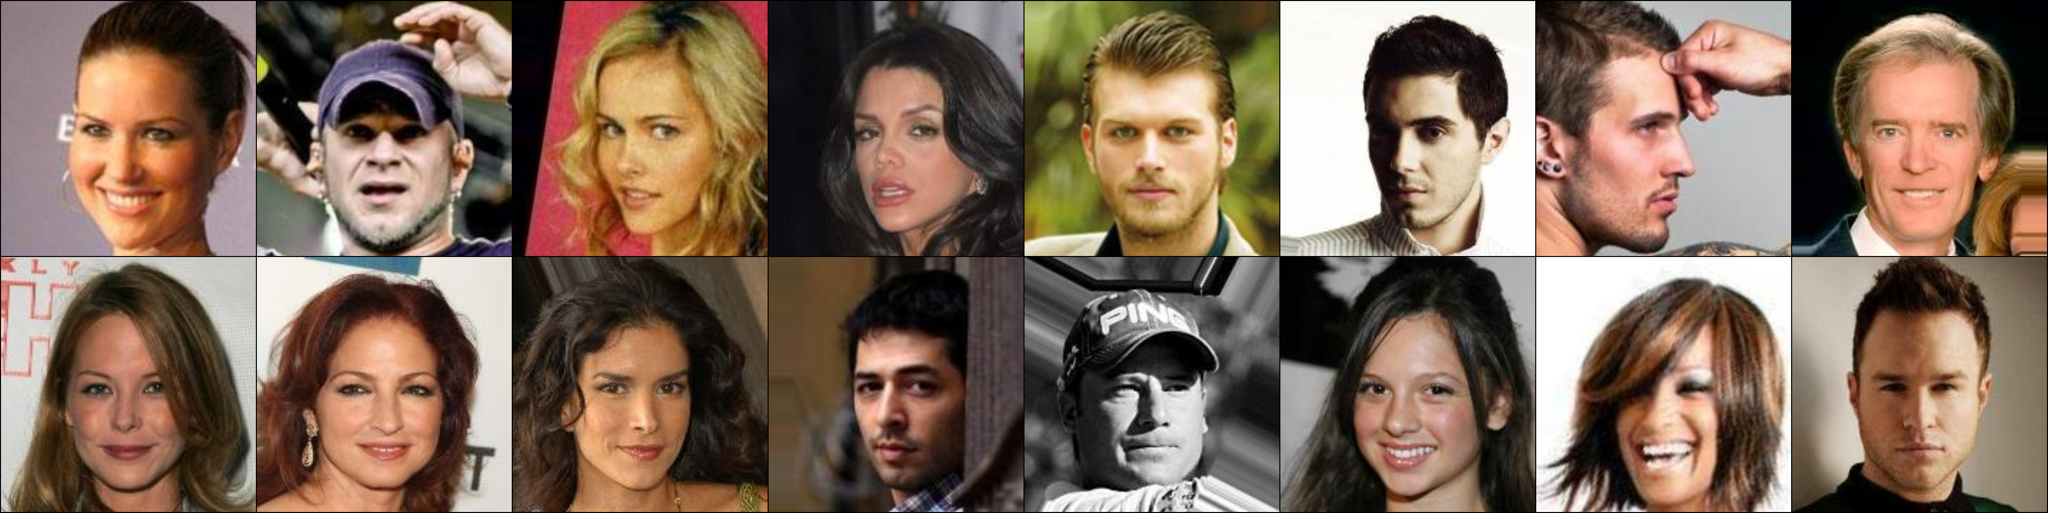

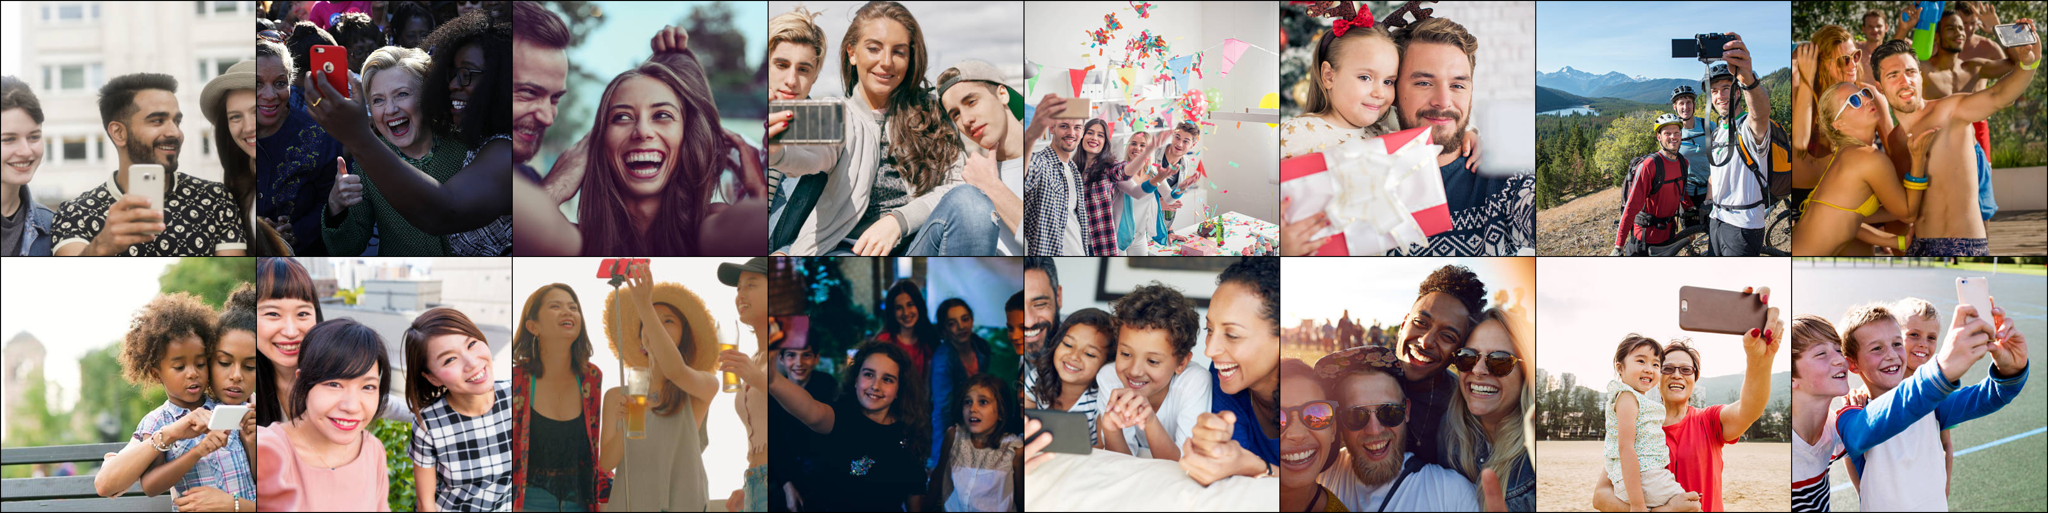

In [2]:
def visualize_original_images(datapath):
    ## This dataset will be for the resting generated 64x64 images
    class ImageDataset(Dataset):
        def __init__(self, root, transform):
            self.root = root
            self.transform = transform
            self.all_imgs = list(sorted(os.listdir(root)))

        def __len__(self):
            return len(self.all_imgs)

        def __getitem__(self, idx):
            image = Image.open(self.root+self.all_imgs[idx])
            image = self.transform(image)
            return image

    batch_size = 16
    image_size= 512

    img_transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




    assert len(os.listdir(datapath)) > 0, "No images found in data path"
    dataset = ImageDataset(datapath, img_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    batch = next(iter(dataloader))
    display_img = Image.fromarray((vutils.make_grid(batch, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
    display(ImageOps.contain(display_img, (2048,2048)))

celeba_datapath = data_path+"img_align_celeba/img_align_celeba/"
group_images = data_path+"train/image_data/"
visualize_original_images(celeba_datapath)
visualize_original_images(group_images)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)

def generate_boxes(img, threshold=0.7):
    try:
        all_boxes, probs, _ = mtcnn.detect(img.copy(), landmarks=True)
    except:
        all_boxes, probs = [], []
    if all_boxes is None: return []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    #gives box values outside of image, e.g. [-6, 135, 69, 229],
    all_boxes = [[max(0, box[0]), max(0, box[1]), box[2], box[3]] for box in all_boxes]
    boxes = []
    for box, prob in zip(all_boxes, probs):
        if prob >= threshold:
            boxes.append(box)
    return boxes

def draw_boxes(img, boxes):
    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box, outline=(255, 0, 0), width=3) # box = (x1, y1, x2, y2)
    return frame_draw

def crop_face(face):
    """Turns image into a square by cropping
    Parameters:
        face: image to crop
        x, y: coordinates of top left corner of face
    
    Returns:
        face: cropped image
        x, y: adjusted x, y coordinates of where cropped face starts
    """
    height, width, _ = face.shape
    if height > width:
        diff = height - width
        top_crop = diff // 2
        bottom_crop = diff - top_crop
        face = face[top_crop:-bottom_crop, :]
    elif width > height:
        diff = width - height
        left_crop = diff // 2
        right_crop = diff - left_crop
        face = face[:, left_crop:-right_crop]

    assert face.shape[0] == face.shape[1], "Face is not square"
    return face

def get_boxes(images_dir, folder_name):
    save_dir = data_path+folder_name+"/"

    if not os.path.exists(save_dir): 
        print("making save folder: ", save_dir)
        os.mkdir(save_dir)

    filenames = list(sorted(os.listdir(images_dir)))
    t_start = time.time()
    faces_saved = 0
    faces_skipped = 0
    for img_idx, image_filename in enumerate(filenames):
        image_path = images_dir + image_filename
        img = Image.open(image_path)
        boxes = generate_boxes(img)
        if folder_name == "celeba_faces_cropped":
            boxes[:1]
        
        for (x1, y1, x2, y2) in boxes: # only first box (most probable and most likely main face)
            height = y2 - y1
            width = x2 - x1
            if height < 64 or width < 64:
                faces_skipped += 1
                continue #skipping images
        
            cropped_face = np.array(img)[y1:y2, x1:x2]
            square_face = crop_face(cropped_face)
            resized_face = Image.fromarray(square_face).resize((img_size, img_size))
            resized_face.save(save_dir + f"{img_idx}_{image_filename}.jpg")
            faces_saved +=1

        if img_idx % 2000 == 0:
            print(f"Processed [{img_idx+1}/{len(filenames)}] images | saved: {faces_saved} | skipped: {faces_skipped} | Time taken: {time.time() - t_start:.2f} seconds")
    print(f"Total images saved: {faces_saved} | skipped: {faces_skipped} | Time taken: {time.time() - t_start:.2f} seconds")

celeba_datapath = data_path+"img_align_celeba/img_align_celeba/"
group_images = data_path+"train/image_data/"
 
print("Length of celeba_filenames:", len(os.listdir(celeba_datapath)))
print("Length of group_filenames:", len(os.listdir(group_images)))

get_boxes(celeba_datapath, "celeba_faces_cropped") 
# get_boxes(group_images, "group_faces_cropped") 

Running on device: cpu
Length of celeba_filenames: 202599
Length of group_filenames: 8196
making save folder:  c:/Users/James/git/de-identification/downloaded-data/celeba_faces_cropped/
Processed [1/202599] images | saved: 1 | skipped: 0 | Time taken: 0.12 seconds
Processed [2001/202599] images | saved: 2001 | skipped: 43 | Time taken: 95.52 seconds
Processed [4001/202599] images | saved: 3998 | skipped: 82 | Time taken: 199.67 seconds
Processed [6001/202599] images | saved: 5996 | skipped: 130 | Time taken: 310.32 seconds
Processed [8001/202599] images | saved: 7997 | skipped: 165 | Time taken: 408.71 seconds
Processed [10001/202599] images | saved: 10002 | skipped: 204 | Time taken: 510.16 seconds
Processed [12001/202599] images | saved: 12000 | skipped: 242 | Time taken: 597.95 seconds
Processed [14001/202599] images | saved: 13999 | skipped: 281 | Time taken: 683.86 seconds
Processed [16001/202599] images | saved: 16001 | skipped: 323 | Time taken: 769.84 seconds
Processed [18001/2

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.all_imgs = list(sorted(os.listdir(root)))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        image = Image.open(self.root+self.all_imgs[idx])
        image = self.transform(image)
        return image
    
def visualize_original_images(datapath):
    ## This dataset will be for the resulting 64x64 cropped images
    print(f"Images for {datapath}")

    batch_size = 32

    img_transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    assert len(os.listdir(datapath)) > 0, "No images found in data path"
    dataset = ImageDataset(datapath, img_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    batch = next(iter(dataloader))
    display_img = Image.fromarray((vutils.make_grid(batch, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
    display(ImageOps.contain(display_img, (2048,2048)))

celeba_faces = data_path+"celeba_faces_cropped/"
group_faces = data_path+"group_faces_cropped/"
visualize_original_images(celeba_faces)
visualize_original_images(group_faces)